# SIR vs. SEIR Model Fitting of Covid-19 Data

**Author: Veronica Scerra**  
**Last Updated: 2025-10-17**

**Purpose:**
Demonstrate SEIR and compare to SIR on OWID Covid-19 data

**Inputs & Dependencies:**
- Code: `src/dataio/load_owid_covid.py`, `src/epimodels/sir.py`, `src/epimodels/seir_custom.py`, `src/epimodels/fitting.py`
- Libraries: `numpy`, `matplotlib`, `pandas`  
- Covid19 data pulled from OWID

**Outputs:**
- 
- 

**Context:**
Fifth notebook in the **SIR Model Project**, serving as a means for expanding to include and incubation paramter (E) for better fit on a slice of real-world data. 

### Import paths and dependencies

In [ ]:
import sys, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from dataio.loaders import load_owid_covid
from epimodels.fitting import fit_beta_gamma, fit_seir_custom

### Load the same country / time window as used in notebook 4 (`04_realdata_baseline.ipynb`)

In [2]:
country = "United States"
df = load_owid_covid(country, source="compact", start="2020-09-01", end="2021-03-01", smooth=7)
t = df["t"].to_numpy(dtype=float)
y = df["incidence_smooth"].to_numpy(dtype=float)
N = int(df["population"].iloc[0])

I0 = max(10, int(0.0005 * N))
E0 = I0 # simple heuristic: start with E0 = I0 and tune if you want

### Fit SIR (baseline)

In [3]:
sir_res = fit_beta_gamma(
    t=t, y_obs=y, N=N, I0=I0, observable="incidence",
    beta_bounds=(0.05, 0.8), gamma_bounds=(1/14, 1/5),
    grid_size=(25,25), refine=True, random_restarts=3)

### Fit SEIR

In [5]:
seir_res = fit_seir_custom(
    t=t, y_obs=y, N=N, I0=I0, E0=E0, observable="incidence",
    beta_bounds=(0.05, 1.0), gamma_bounds=(1/14, 1/5), sigma_bounds=(1/7, 1/2),
    grid_size=(15, 15, 10), refine=True, random_restarts=2)

### Plot fit vs. data

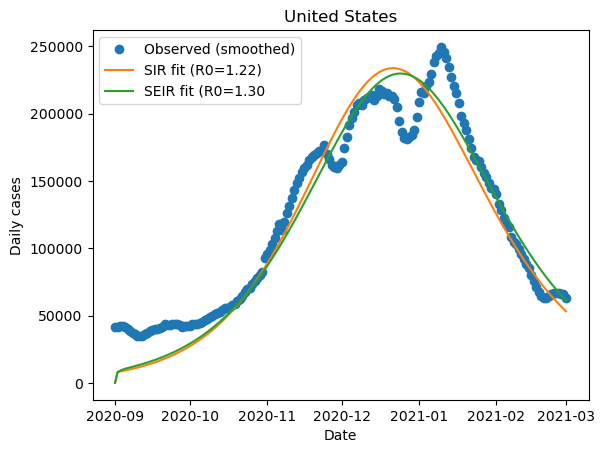

In [6]:
plt.figure()
plt.plot(df["date"], y, marker='o', linestyle="", label="Observed (smoothed)")
plt.plot(df["date"], sir_res["y_fit"], label=f"SIR fit (R0={sir_res['R0']:.2f})")
plt.plot(df["date"], seir_res["y_fit"], label=f"SEIR fit (R0={seir_res['R0']:.2f}")
plt.ylabel("Daily cases"); plt.xlabel("Date"); plt.title(country); plt.legend(); plt.show()

### Inspect fitted trajectories

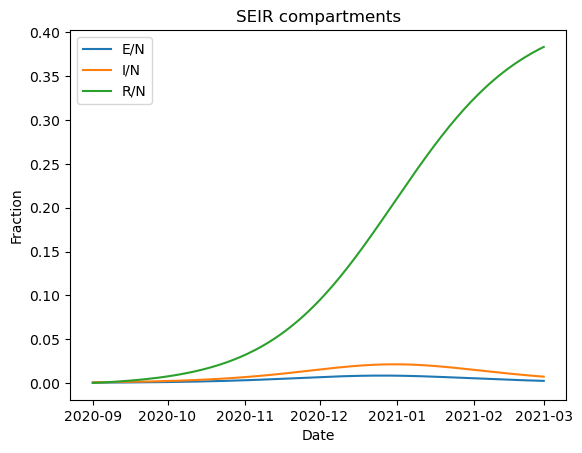

: 

In [ ]:
sim = seir_res["sim"]
plt.figure()
plt.plot(df["date"], sim["E"]/N, label="E/N")
plt.plot(df["date"], sim["I"]/N, label="I/N")
plt.plot(df["date"], sim["R"]/N, label="R/N")
plt.ylabel("Fraction"); plt.xlabel("Date"); plt.legend(); plt.title("SEIR compartments")
plt.show()

SEIR is slightly better at capturing the delay and peak of the Covid-19 data, but it's failing in terms of understanding the various overlapping spikes and population-wide dynamics. Part of the problem is that SEIR is using a constant transmission. Next I will move on to adding a varying transmission rate with piecewise $\beta$